In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from caveclient import CAVEclient

import sys
sys.path.append('utils')
from FANC_utils import filter_syn_df, convert_to_nm

In [2]:
# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

In [62]:
# Load table 

# Select claw or hook neurons
cell_type = ['claw_flx','claw_ext']
#cell_type = ['hook_flx','hook_ext']

df = client.materialize.query_table('feco_axons_v0', 
                                    filter_in_dict = {'cell_type': cell_type})

# Exclude partially reconstructed claw axons
if 'claw_flx' in cell_type:
    pt_position_to_exclude = np.array([[9093, 101264, 3740], [9401, 100947, 3740]])
    ix_to_exclude = []
    for ix, i in df.iterrows():
        if (df.pt_position[ix]==pt_position_to_exclude).all(axis=1).any():
            ix_to_exclude.append(ix)
    df = df.drop(ix_to_exclude)

In [30]:
# Get IDs of FeCO neurons
feco_ids = df.pt_root_id.tolist()

In [56]:
# Query input or output synapses 
query_input_syn = True
if query_input_syn == True:
    syn_df = client.materialize.synapse_query(post_ids = feco_ids)
else:
    syn_df = client.materialize.synapse_query(pre_ids = feco_ids)

In [57]:
# Remove connections less than syn_thresh from syn_df
syn_thresh = 3
syn_df = filter_syn_df(syn_df, syn_thresh)

In [44]:
# Convert synapse positions to nm
syn_input_pos_filt = convert_to_nm(syn_df.post_pt_position)
syn_output_pos_filt = convert_to_nm(syn_df.pre_pt_position)

# Note that y points posteriorly in Neuroglancer, so flip sign 
syn_input_pos_filt[:,1] = -syn_input_pos_filt[:,1]
syn_output_pos_filt[:,1] = -syn_output_pos_filt[:,1]

In [45]:
# Select whether to plot presynaptic sites (input synapses) or postsynaptic sites to plot 
if query_input_syn == True:
    x = syn_input_pos_filt[:,0]
    y = syn_input_pos_filt[:,1]
    print('Number of synapses: ' + str(len(syn_input_pos_filt)))
else:
    x = syn_output_pos_filt[:,0]
    y = syn_output_pos_filt[:,1]
    print('Number of synapses: ' + str(len(syn_output_pos_filt)))

Number of synapses: 233


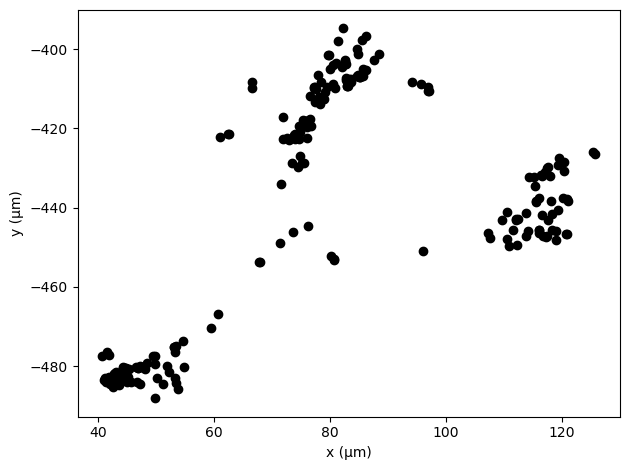

In [46]:
# Plot synapse positions in x-y plane in micrometers
fig, ax = plt.subplots()
ax.scatter(x/1000, y/1000, color=color, alpha=1)
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.tight_layout()
plt.show()